# Plan:
1. Do a round of regular QAOA, keeping the lowest-energy bitstring.
1. Using this bitstring, do $p$ rounds of cQAOA with fixed $\alpha$,
and make a heatmap of energy vs. $\gamma$ and $\beta$.
1. Repeat for different values of $\alpha$.

In [7]:
from typing import List, Tuple
import h5py
import numpy as np
import cirq
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathos.pools import ProcessPool
from cqaoa.ansatz import CylicQAOAAnsatz
from cqaoa.maxcut import edge_operator, maxcut_hamiltonian, bitstring_energy

In [8]:
n = 16
p = 2
qs = cirq.LineQubit.range(n)
qubit_graph = nx.Graph()
for i in range(len(qs)):
    qubit_graph.add_edge(qs[i], qs[(i+1) % len(qs)])
hamiltonian = maxcut_hamiltonian(qubit_graph)
alpha = np.zeros(p)
print(alpha.shape)
ref = np.array([False] * n, dtype=bool)
ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian, alpha=alpha, reference=ref)

(2,)


In [9]:
def optimize_ansatz(ansatz: CylicQAOAAnsatz, gamma0: float, beta0: float, p: int):

    def objective_callback(params: np.ndarray) -> float:
        """Get energy for p rounds with equal gamma and beta.
        Should pass [gamma, beta]"""

        assert params.size == 2
        n = len(ansatz.qubits)
        gammas = np.array([params[0]] * p)
        betas = np.array([params[1]] * p)
        return ansatz.energy(gammas, betas)
    
    vars0 = np.array([gamma0, beta0])
    opt_result = minimize(objective_callback, vars0, method="Powell", options={"maxiter": 1_000_000})
    assert opt_result.success, f"Optimizer failed: {opt_result.message}"
    optimized_energy =  objective_callback(opt_result.x)
    assert opt_result.x.size == 2
    gamma_opt = opt_result.x[0]
    beta_opt = opt_result.x[1]
    return optimized_energy, gamma_opt, beta_opt

In [10]:
gamma0 = 0.1
beta0 = 0.2
energy, gamma_opt, beta_opt = optimize_ansatz(ansatz, gamma0, beta0, p)
print(f"Final energy = {energy}")
print(f"gamma = {gamma_opt} beta = {beta_opt}")

Final energy = -12.336836283034373
gamma = 3.8419124042996766 beta = 0.15786523280033063


In [11]:
gammas = np.array([gamma_opt] * p)
betas = np.array([beta_opt] * p)
samples = ansatz.sample_bitstrings(gammas, betas, 10_000)
print(samples.head())

   q(6)  q(1)  q(9)  q(4)  q(3)  q(0)  q(11)  q(12)  q(7)  q(2)  q(13)  q(8)  \
0     1     0     0     1     0     1      0      1     1     1      0     0   
1     0     0     0     0     1     1      0      0     1     0      1     0   
2     0     1     0     0     0     0      1      0     0     1      1     1   
3     1     0     0     1     1     0      0      1     1     1      1     0   
4     1     0     1     1     0     0      1      0     1     1      1     0   

   q(14)  q(15)  q(10)  q(5)  
0      1      0      1     0  
1      0      0      1     1  
2      0      1      1     1  
3      0      1      1     0  
4      0      1      0     0  


In [ ]:
# Get the bitstring with the lowest energy.

def cirq_samples_to_sorted_ndarray(samples: pd.DataFrame) -> np.ndarray:
    """Cirq returns a dataframe of samples with column names like q(12).
    We want to sort these clumns by their integer values and then convert the DataFrame
    to an np array of booleans."""

    nsamples = len(samples)
    ncols = len(samples.columns)

    col_name_index_pairs: List[Tuple[str, int]] = []
    for col_name in samples.columns:
        digits = ''.join(c for c in col_name if c.isdigit())
        if len(digits) == 0:
            raise ValueError(f"Column name {col_name} has no digits.")
        col_name_index_pairs.append((col_name, int(digits)))
    # Sort the column name, index pairs by the index.
    sorted_indices = sorted(col_name_index_pairs, key=lambda t: t[1])
    sorted_column_names = [t[0] for t in sorted_indices]
    # Put columnns into the array in order.
    samples_np = np.zeros((nsamples, ncols), dtype=bool)
    for i, col in enumerate(sorted_column_names):
        bool_column = samples[col].to_numpy()
        samples_np[:, i] = bool_column.copy()
    return samples_np

def lowest_energy(samples):
    sample_array = cirq_samples_to_sorted_ndarray(samples)
    sample_energies = [bitstring_energy(bs, hamiltonian) for bs in sample_array]
    min_energy_idx = np.argmin(sample_energies)
    min_energy_bitstring = sample_array[min_energy_idx, :]
    return (sample_energies[min_energy_idx], min_energy_bitstring)

min_energy, min_energy_bitstring = lowest_energy(samples)
print(f"Bitstring \n{min_energy_bitstring}\nhas energy {min_energy}.")

In [ ]:
def energy_heatmap(
    gammas: np.ndarray, betas: np.ndarray, alpha: float,
    bitstring: np.ndarray, graph: nx.Graph, p: int, shots
) -> Tuple[np.ndarray, ...]:
    """Construct an energy heatmap for p rounds of cQAOA with equal gamma
    and beta for each round."""

    hamiltonian = maxcut_hamiltonian(graph)
    alphas = np.array([alpha] * p)
    ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian, alpha=alphas, reference=bitstring)

    energies = np.zeros((gammas.size, betas.size), dtype=float)
    sampled_energies = np.zeros((gammas.size, betas.size), dtype=float)
    for i, gamma in enumerate(gammas):
        for j, beta in enumerate(betas):
            ckt_gammas = np.array([gamma] * p)
            ckt_betas = np.array([beta] * p)
            samples = ansatz.sample_bitstrings(ckt_gammas, ckt_betas, 10_000)
            sample_energy, _ = lowest_energy(samples)
            energies[i, j] = ansatz.energy(ckt_gammas, ckt_betas)
            sampled_energies[i, j] = sample_energy
    return (energies, sampled_energies) 

shots = 10_000
gammas = np.linspace(0., 4., num=20)
betas = np.linspace(0., 1., num=20)
alphas = np.linspace(0., 1.0, num=5)
all_energies = np.zeros((gammas.size, betas.size, alphas.size), dtype=float)
all_sampled_energies = np.zeros((gammas.size, betas.size, alphas.size), dtype=float)
# for i, alpha in enumerate(alphas):
#     energies, sampled_energies = energy_heatmap(
#         gammas, betas, alpha, min_energy_bitstring, qubit_graph, p, shots
#     )
#     all_energies[:, :, i] = energies
#     all_sampled_energies[:, :, i] = sampled_energies
pool = ProcessPool(nodes=5)
results = pool.map(lambda alpha: energy_heatmap(gammas, betas, alpha, min_energy_bitstring, qubit_graph, p, shots), alphas)
for i, (energies, samples) in enumerate(results):
    all_energies[:, :, i] = energies
    all_sampled_energies[:, :, i] = samples

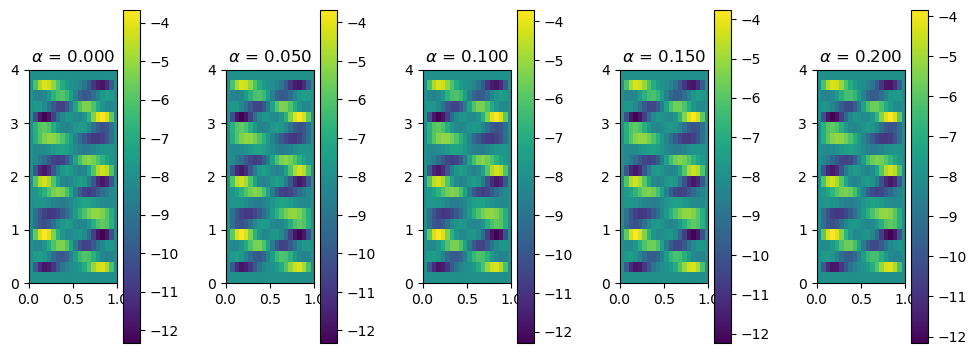

In [ ]:
fig, ax = plt.subplots(1, alphas.size, figsize=(10., 6.))
extent = (np.min(betas), np.max(betas), np.min(gammas), np.max(gammas))
for i, alpha in enumerate(alphas):
    im = ax[i].imshow(all_energies[:, :, i], extent=extent, aspect=0.6)
    ax[i].set_title(f"$\\alpha$ = {alpha:0.3f}")
    plt.colorbar(im, ax=ax[i])
plt.tight_layout()

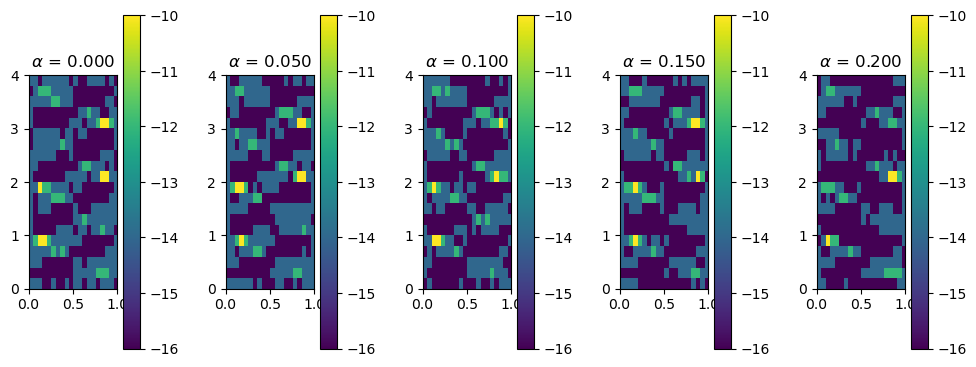

In [ ]:
fig2, ax2 = plt.subplots(1, alphas.size, figsize=(10., 6.))
extent = (np.min(betas), np.max(betas), np.min(gammas), np.max(gammas))
for i, alpha in enumerate(alphas):
    im = ax2[i].imshow(all_sampled_energies[:, :, i], extent=extent, aspect=0.6)
    ax2[i].set_title(f"$\\alpha$ = {alpha:0.3f}")
    plt.colorbar(im, ax=ax2[i])
plt.tight_layout()

In [ ]:
f = h5py.File("../data/equal_gab.hdf5", "w")
f.create_dataset("gammas", data=gammas)
f.create_dataset("betas", data=betas)
f.create_dataset("alphas", data=alphas)
f.create_dataset("reference", data=min_energy_bitstring)
f.create_dataset("all_energies", data=all_energies)
f.create_dataset("all_sampled_energies", data=all_sampled_energies)
f.close()